#**Stacking and Blending (Classification)**

**Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import clone

**Code**

In [2]:
# Load a classification dataset
data = fetch_california_housing()
X, y = data.data, data.target
y = (y > y.mean()).astype(int)  # Convert to binary classification

In [3]:
# Split the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Further split the training set into train and validation sets (for stacking)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [5]:
# Define base classifiers with more estimators
base_classifiers = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),  # SVC needs probability=True for blending
    ('knn', KNeighborsClassifier(n_neighbors=5)),
]

In [6]:
# Step 1: Train base classifiers on the training set
val_predictions = np.zeros((X_val.shape[0], len(base_classifiers)))  # Placeholder for validation predictions
test_predictions = np.zeros((X_test.shape[0], len(base_classifiers)))  # Placeholder for test set predictions
fitted_classifiers = []  # To store fitted classifier instances

for i, (name, clf) in enumerate(base_classifiers):
    # Clone the classifier to avoid overwriting during stacking
    clf_instance = clone(clf)

    # Train on the full training set
    clf_instance.fit(X_train, y_train)
    fitted_classifiers.append(clf_instance)  # Store the fitted instance

    # Store predictions on the validation set (for blending)
    val_predictions[:, i] = clf_instance.predict(X_val)

    # Store predictions on the test set
    test_predictions[:, i] = clf_instance.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [7]:
# Step 2: Stack the base classifier predictions and train a meta-classifier
stacking_meta_classifier = LogisticRegression()
stacking_meta_classifier.fit(val_predictions, y_val)

LogisticRegression()

In [8]:
# Step 3: Make final predictions on the test set using the stacking meta-classifier
final_stacking_predictions = stacking_meta_classifier.predict(test_predictions)

In [9]:
# Calculate and display the accuracy of the stacking model
stacking_accuracy = accuracy_score(y_test, final_stacking_predictions)
print(f'Stacking Model Accuracy: {stacking_accuracy:.2f}')

Stacking Model Accuracy: 0.89


In [10]:
# Step 4: Blending approach
# Blending predictions from base classifiers on the test set using Logistic Regression
blender = LogisticRegression()
blender.fit(val_predictions, y_val)

LogisticRegression()

In [11]:
# Make final predictions using the blender
final_blender_predictions = blender.predict(test_predictions)

In [12]:
# Calculate and display the accuracy of the blended model
blender_accuracy = accuracy_score(y_test, final_blender_predictions)
print(f'Blended Model Accuracy: {blender_accuracy:.2f}')

Blended Model Accuracy: 0.89


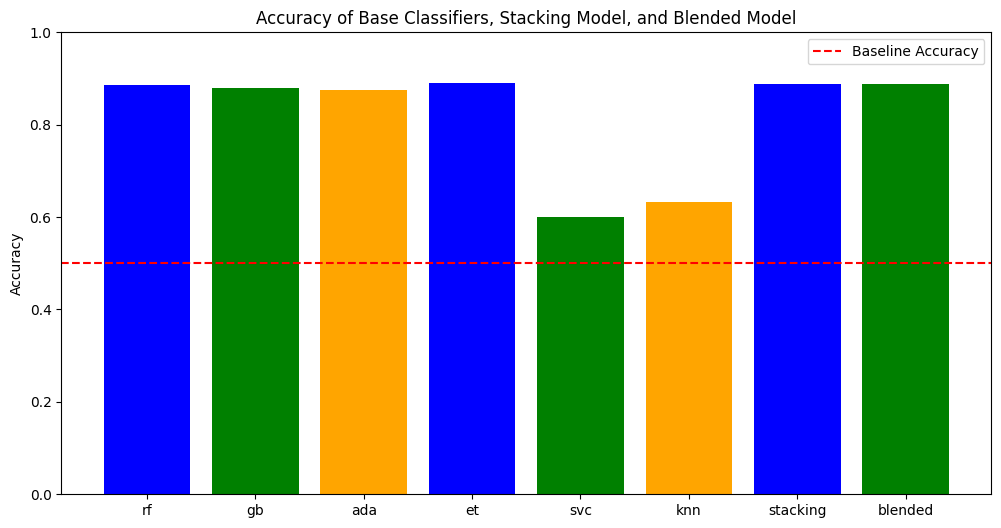

In [13]:
# Visualize individual classifier performance, stacking model, and blended model performance
individual_accuracies = []

for clf_instance, (name, _) in zip(fitted_classifiers, base_classifiers):
    clf_pred = clf_instance.predict(X_test)
    acc = accuracy_score(y_test, clf_pred)
    individual_accuracies.append((name, acc))

# Plot individual classifier accuracy vs. stacking and blended model accuracy
names, accs = zip(*individual_accuracies)
plt.figure(figsize=(12, 6))
plt.bar(names + ('stacking', 'blended'), accs + (stacking_accuracy, blender_accuracy), color=['blue', 'green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Accuracy of Base Classifiers, Stacking Model, and Blended Model')
plt.ylim(0, 1)
plt.axhline(y=0.5, color='red', linestyle='--', label='Baseline Accuracy')
plt.legend()
plt.show()

In [14]:
# Visualizing Confusion Matrix for Stacking and Blended Model
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

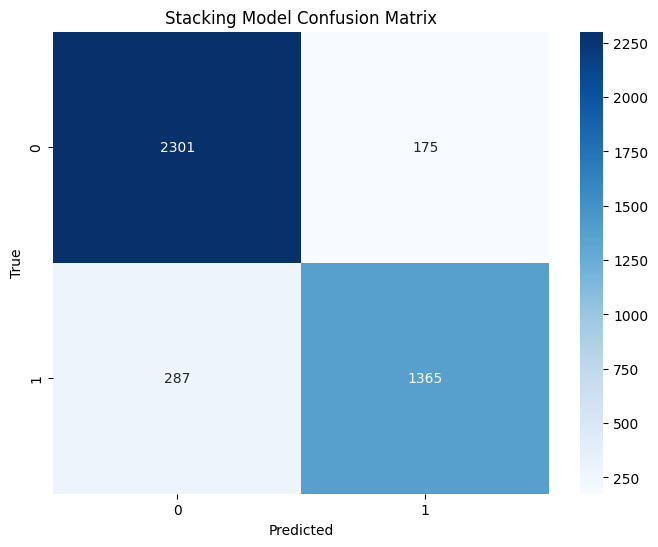

In [15]:
# Confusion Matrix for Stacking Model
plot_confusion_matrix(y_test, final_stacking_predictions, title='Stacking Model Confusion Matrix')

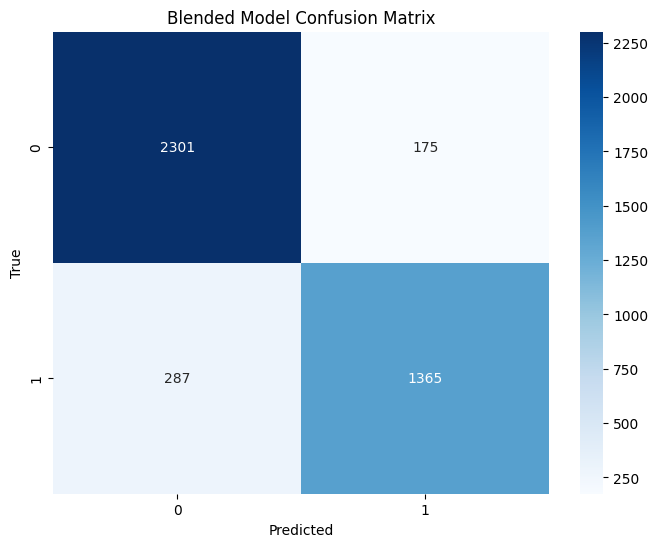

In [16]:
# Confusion Matrix for Blended Model
plot_confusion_matrix(y_test, final_blender_predictions, title='Blended Model Confusion Matrix')

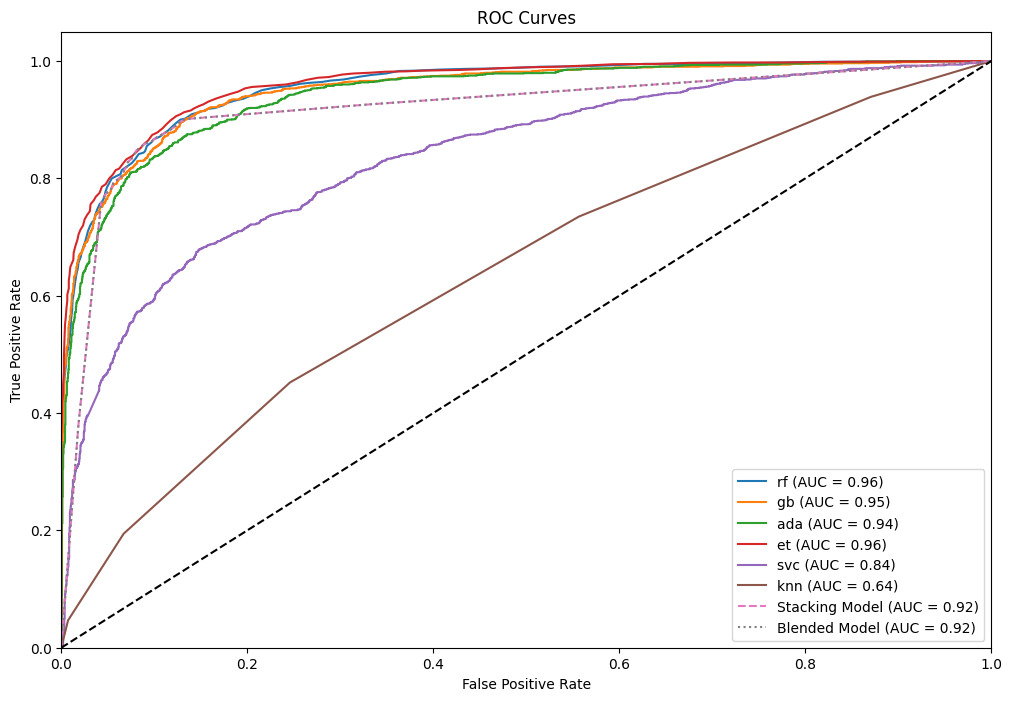

In [17]:
# Visualizing ROC Curves for Base Classifiers, Stacking, and Blended Models
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 8))
for clf_instance, (name, _) in zip(fitted_classifiers, base_classifiers):
    # Calculate ROC curve
    y_pred_proba = clf_instance.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

# ROC for Stacking Model
y_pred_proba_stacking = stacking_meta_classifier.predict_proba(test_predictions)[:, 1]
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, y_pred_proba_stacking)
plt.plot(fpr_stacking, tpr_stacking, label=f'Stacking Model (AUC = {auc(fpr_stacking, tpr_stacking):.2f})', linestyle='--')

# ROC for Blended Model
y_pred_proba_blender = blender.predict_proba(test_predictions)[:, 1]
fpr_blender, tpr_blender, _ = roc_curve(y_test, y_pred_proba_blender)
plt.plot(fpr_blender, tpr_blender, label=f'Blended Model (AUC = {auc(fpr_blender, tpr_blender):.2f})', linestyle=':')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()